In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

# Import standard libraries
import os, sys
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
import copy
import astropy.units as u
import emcee, corner
import seaborn as sns
import pandas as pd

import chimera

import coronagraph as cg
import smart
import smarter; smarter.utils.plot_setup()

/Users/lustija1/opt/anaconda3/lib/python3.8/site-packages/pysynphot/locations.py:345: UserWarning: Extinction files not found in /Users/lustija1/Documents/PandExo_data/pysynphot_data/extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))
/Users/lustija1/opt/anaconda3/lib/python3.8/site-packages/pysynphot/refs.py:117: UserWarning: No graph or component tables found; functionality will be SEVERELY crippled. No files found for /Users/lustija1/Documents/PandExo_data/pysynphot_data/mtab/*_tmg.fits
  warnings.warn('No graph or component tables found; '
/Users/lustija1/opt/anaconda3/lib/python3.8/site-packages/pysynphot/refs.py:124: UserWarning: No thermal tables found, no thermal calculations can be performed. No files found for /Users/lustija1/Documents/PandExo_data/pysynphot_data/mtab/*_tmt.fits
  warnings.warn('No thermal tables found, '


In [2]:
def extract_flatchain(ep, tag, iburn, mad_cut = None):
    
    # Create useful things
    emcee_backend = str(tag) + "_emcee.h5"
    theta_names = ep.THETA_NAMES
    theta0 = ep.THETA0

    # Create an HDF5 backend
    backend = emcee.backends.HDFBackend(emcee_backend)
   
    if mad_cut is None:
        
        # Use all walkers
        flatchain = backend.get_chain(flat=True, discard = iburn)
        
        # Mask for all walkers
        m = np.array([True for _ in range(backend.shape[0])])
        
    else:
        
        # Index of parameter to apply mad cut
        imad = mad_cut[0]
        
        # Number of mads away from median at which to cut
        nmad = mad_cut[1]
        
        # Cut chains by the MAD 
        chain = backend.get_chain(flat=False, discard = iburn)
        tmp = np.median(chain, axis=0)[:,imad]
        #np.median(tmp), np.median(np.fabs(tmp - np.median(tmp)))
        m = np.fabs(tmp - np.median(tmp)) < nmad*np.median(np.fabs(tmp - np.median(tmp)))
        flatchain = chain[:,m,:].reshape((-1, len(theta_names)))
        
    print("using", m.sum(), "of",  m.size, "walkers")
    
    wl = np.array(ep.wl)
    y_binned = np.array(ep.y_binned)
    y_meas = np.array(ep.y_meas)
    y_err = np.array(ep.y_err)
        
    # Get spectra
    blobs = backend.get_blobs(flat=False, discard = iburn)
    Fobs_post, Fstar_post, Fplan_post = blobs[:,m,0,:].reshape((-1, len(ep.wl))), blobs[:,m,1,:].reshape((-1, len(ep.wl))), blobs[:,m,2,:].reshape((-1, len(ep.wl)))

    return flatchain, dict(wl=wl, y_binned=y_binned, y_meas=y_meas, y_err=y_err, 
                           Fobs_post=Fobs_post, Fstar_post=Fstar_post, Fplan_post=Fplan_post)



In [19]:
#from run_wasp43_mcmc_texp import exopie as exopie_all4; tag = "test_allin4"; iburn=2000
from run_wasp43_free_allin4 import exopie as exopie_all4; tag = "test_free_allin4"; iburn=4500
chain_all4, spectra_all4 = extract_flatchain(exopie_all4, tag, iburn, mad_cut=None)

using 140 of 140 walkers


In [20]:
#from run_wasp43_mcmc_texp import exopie as exopie_all4; tag = "test_allin4"; iburn=2000
from run_wasp43_free_allin4_zodi3 import exopie as exopie_zodi3; tag = "test_free_allin4_zodi3"; iburn=1000
chain_zodi3, spectra_zodi3 = extract_flatchain(exopie_zodi3, tag, iburn, mad_cut=None)

using 140 of 140 walkers


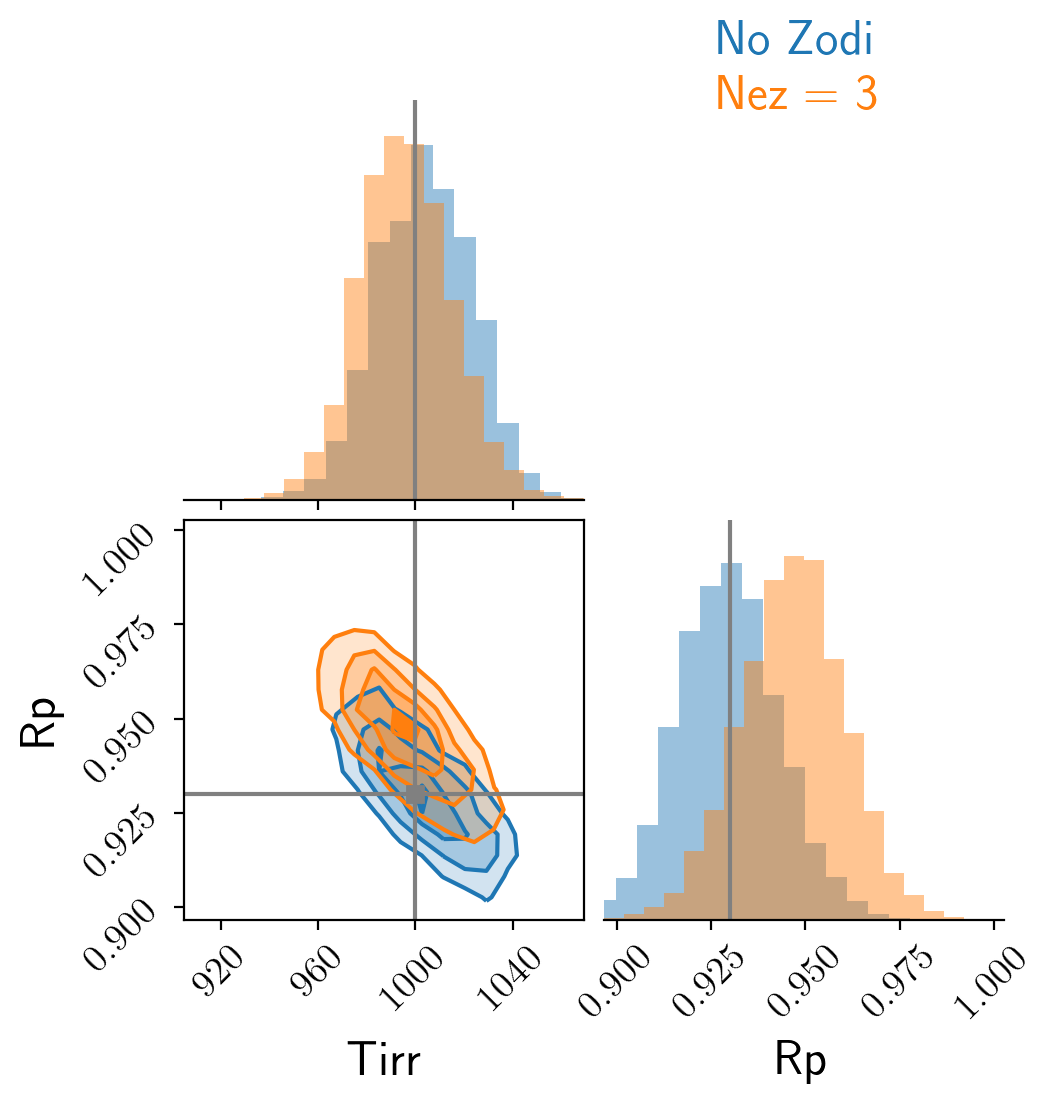

In [26]:
var_names = ["Tirr", "Rp"]

color1 = "C0"
color2 = "C1"
title1 = "No Zodi"
title2 = "Nez = 3"
smooth = None
labels = exopie_all4.THETA_NAMES
theta0 = exopie_all4.THETA0

vtag = str(var_names).replace(",", "").replace("'", "").replace(" ", "_").replace("[", "").replace("]", "")
theta_dict = dict(zip(labels, theta0))
t0 = [theta_dict[v] for v in var_names]

df = pd.DataFrame(chain_all4, columns=labels)
fig = corner.corner(df[var_names].values, labels = var_names, truths=t0, truth_color="gray", color = color1, show_titles = True, scale_hist=True,
                    plot_contours=True, plot_points = True, plot_density = True, 
                    hist_kwargs = {"alpha" : 0.45, "histtype" : "stepfilled"}, 
                    no_fill_contours=True, plot_datapoints=False, fill_contours=True, 
                    smooth = smooth)

# Save the titles and ylims for the first corner
ndim = len(var_names)
axes = np.reshape(fig.axes, (ndim, ndim))
fig_titles = []
fig_ylims = []
for i in range(ndim):
    for j in range(ndim):
        if i == j:
            #print(axes[i,j].get_title()) 
            #print(axes[i,j].get_ylim())
            fig_titles.append(axes[i,j].get_title())
            fig_ylims.append(axes[i,j].get_ylim())
        else:
            pass

df = pd.DataFrame(chain_zodi3, columns=labels)
fig = corner.corner(df[var_names].values, fig = fig, color = color2, 
                    labels = var_names, show_titles = True, scale_hist=True,
                    plot_contours=True, plot_density = True, 
                    hist_kwargs = {"alpha" : 0.45, "histtype" : "stepfilled", "lw" : 1.0, "ls" : "-"}, 
                    no_fill_contours=True, plot_datapoints=False, fill_contours=True, 
                    smooth = smooth)

# Save the titles and ylims for the second corner
axes = np.reshape(fig.axes, (ndim, ndim))
fig_titles2 = []
fig_ylims2 = []
for i in range(ndim):
    for j in range(ndim):
        if i == j:
            #print(axes[i,j].get_title()) 
            #print(axes[i,j].get_ylim())
            fig_titles2.append(axes[i,j].get_title())
            fig_ylims2.append(axes[i,j].get_ylim())
        else:
            pass
"""
fig = corner.corner(chain_mirilrs, fig = fig, color = color3, 
                    labels = labels, show_titles = True, scale_hist=True,
                    plot_contours=True, plot_density = True, 
                    hist_kwargs = {"alpha" : 0.45, "histtype" : "stepfilled", "lw" : 1.0, "ls" : "-"}, 
                    no_fill_contours=True, plot_datapoints=False, fill_contours=True, 
                    smooth = smooth)


# Save the titles and ylims for the second corner
axes = np.reshape(fig.axes, (ndim, ndim))
fig_titles3 = []
fig_ylims3 = []
for i in range(ndim):
    for j in range(ndim):
        if i == j:
            #print(axes[i,j].get_title()) 
            #print(axes[i,j].get_ylim())
            fig_titles3.append(axes[i,j].get_title())
            fig_ylims3.append(axes[i,j].get_ylim())
        else:
            pass
"""

# Make title
fig.text(2.0 / (ndim+1), 1.0 - 0.1*(0./ndim), title1, color = color1, ha = "left", va = "top", fontsize = 18)
fig.text(2.0 / (ndim+1), 1.0 - 0.1*(1./ndim), title2, color = color2, ha = "left", va = "top", fontsize = 18)
#fig.text(2.0 / (ndim+1), 1.0 - 0.3*(2./ndim), title3, color = color3, ha = "left", va = "top", fontsize = 18)

ymaxes = np.max(np.array((fig_ylims, fig_ylims2)), axis=0)[:,1]

# Make merge titles along diagonal 
axes = np.reshape(fig.axes, (ndim, ndim))
for i in range(ndim):
    for j in range(ndim):
        if i == j:
            #print(axes[i,j].get_title()) 
            #print(axes[i,j].get_ylim())
            text = axes[i,j].get_title()
            text += "\n" + fig_titles[i]
            #text += "\n" + fig_titles2[i]
            #axes[i,j].set_title(text, fontsize = 18)
            #t1 = axes[i,j].text(0.0, 1.175, axes[i,j].get_title(), ha = "left", va = "bottom", color = color2, transform = axes[i,j].transAxes)
            #t2 = axes[i,j].text(0.0, 1.175, fig_titles[i], ha = "left", va = "top", color = color1, transform = axes[i,j].transAxes)
            #t3 = axes[i,j].text(0.0, 1.175, fig_titles2[i], ha = "left", va = "top", color = color3, transform = axes[i,j].transAxes)
            text = None
            axes[i,j].set_title(text, fontsize = 14)
            axes[i,j].set_ylim(bottom = 0.0, top = ymaxes[i])
        else:
            pass

# Adjust axis labels
for i, ax in enumerate(fig.axes):
    ax.xaxis.label.set_fontsize(18)
    ax.yaxis.label.set_fontsize(18)
    ax.title.set_fontsize(18)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(14)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(14)
    if i%(len(var_names)+1)==0:    
        ax.spines["top"].set_visible(False)
        ax.spines["left"].set_visible(False)
        ax.spines["right"].set_visible(False)

fig.savefig("/Users/lustija1/Documents/exoPIE_IRAD/W43b_PIE_retrieval_corner_%s_%s.png" %(tag, vtag), bbox_inches = "tight")
